## **Quickstart Guide**

This guide covers the standard usage pattern and basic functionality to help you get started with twinLab. In this jupyter notebook we will:

1. Upload a dataset to twinLab.
2. Use `tl.train_campaign` to create a surrogate model.
3. Use the model to make a prediction with `tl.predict_campaign`.
4. Visualise the results and their uncertainty.


In [1]:
# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Project imports
import twinlab as tl


         === TwinLab Client Initialisation ===
         Version  : 1.5.0
         User     : alexander
         Credits  : 1000
         Server   : https://twinlab.digilab.co.uk
         Key      : dg4Je8SwoFZ-o_KdVOpvkg



### **Your twinLab information**

Confirm your twinLab version


In [2]:
tl.get_versions()

{'cloud': '2.0.0',
 'modal': '0.2.0',
 'library': '1.2.0',
 'image': 'twinlab-prod'}

And view your user information, including how many credits you have.


In [3]:
tl.get_user_information()

{'username': 'alexander', 'credits': 1000}

### **Upload a dataset**

Datasets must be data presented as a `pandas.DataFrame` object, or a filepaths which points to a csv file that can be parsed to a `pandas.DataFrame` object. **Both must be formatted with clearly labelled columns.** Here, we will label the input (predictor) variable `x` and the output variable `y`. In `twinlab`, data is expected to be in column-feature format, meaning each row represents a single data sample, and each column represents a data feature.

Datasets must be uploaded with a `dataset_id` which is used to access them from the cloud.


In [4]:
x = [
    0.6964691855978616,
    0.28613933495037946,
    0.2268514535642031,
    0.5513147690828912,
    0.7194689697855631,
    0.42310646012446096,
    0.9807641983846155,
    0.6848297385848633,
    0.48093190148436094,
    0.3921175181941505,
]

y = [
    -0.8173739564129022,
    0.8876561174050408,
    0.921552660721474,
    -0.3263338765412979,
    -0.8325176123242133,
    0.4006686354731812,
    -0.16496626502368078,
    -0.9607643657025954,
    0.3401149876855609,
    0.8457949914442409,
]

# Creating the dataframe using the above arrays
df = pd.DataFrame({"x": x, "y": y})

# View the dataset before uploading
display(df)

# Define the name of the dataset
dataset_id = "example_data"

# Upload the dataset to the cloud
tl.upload_dataset(df, dataset_id, verbose=True)

,x,y
0,0.696469,-0.817374
1,0.286139,0.887656
2,0.226851,0.921553
3,0.551315,-0.326334
4,0.719469,-0.832518
5,0.423106,0.400669
6,0.980764,-0.164966
7,0.684830,-0.960764
8,0.480932,0.340115
9,0.392118,0.845795


Dataframe is uploading.
Processing dataset.
Dataset example_data was processed.


If your data is stored in a csv file the you must input the filepath string into `tl.upload_dataset`.


In [5]:
# Local dataset filepath
df_filepath = "./resources/datasets/example_data.csv"

# Define the name of the dataset
dataset_id = "example_data"

# Upload the dataset to the cloud
tl.upload_dataset(df_filepath, dataset_id, verbose=True)

File ./resources/datasets/example_data.csv is uploading.
Processing dataset.
Dataset example_data was processed.


### **Train a campaign**

The `campaign` class is used to train and implement your surrogate models. As with datasets, an id is defined, this is what the model will be saved as in the cloud. When training a model the arguments are passed using a dictionary; here we name that dictionary `campaign_params`. To train the model we use the `tl.train_campaign` function, inputting the dictionary and `campaign_id`.


In [6]:
# Name of the campaign
campaign_id = "example_campaign"

# Define the parameters of the campaign
campaign_params = {
    "dataset_id": dataset_id,  # This points the campaign to the uploaded dataset
    "inputs": ["x"], # List of columns to use as input
    "outputs": ["y"], # List of columns to use as output
    "test_train_ratio": 1.,  # Here we use all the data to train the model
} 

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model example_campaign has begun training.


### **Using a predict campaign**

The surrogate model is now trained and saved to the cloud under the `campaign_id`. It can now be used to make predictions. First define a dataset of inputs for which you want to find outputs; ensure that this is a `pandas.DataFrame` object or a file path for a correctly formatted csv. Then call `tl.predict_campaign` with the keyword arguments being the evaluation dataset and the `campaign_id` of the model you wish to use.


In [7]:
# Define the inputs to make predictions on
x_eval = np.linspace(0, 1, 128)

# Convert to a dataframe
df_eval = pd.DataFrame({"x": x_eval})
display(df_eval)

# Predict the results
df_mean, df_std = tl.predict_campaign(df_eval, campaign_id)

,x
0,0.000000
1,0.007874
2,0.015748
3,0.023622
4,0.031496
...,...
123,0.968504
124,0.976378
125,0.984252
126,0.992126


Alternatively the dataset can be input from a correctly formatted csv using its filepath.


In [8]:
# The define the file path of the csv
df_eval_filepath = "./resources/datasets/example_eval.csv"

# Predict the results
df_mean, df_std = tl.predict_campaign(df_eval_filepath, campaign_id)

### **Viewing the results**

`tl.predict_campaign` outputs mean values for each input and their standard deviation; this gives the abilty to nicely visualise the uncertainty in results.


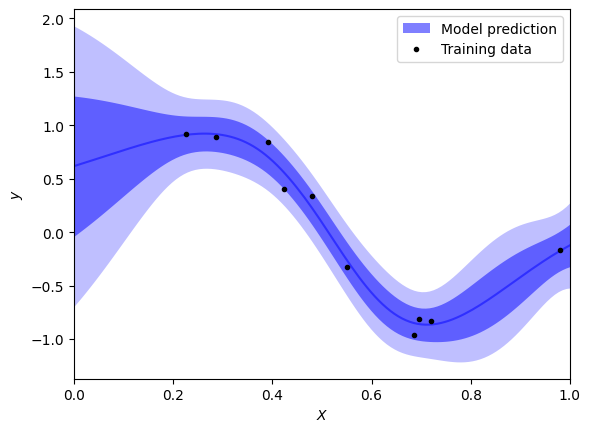

In [9]:
# Plot parameters
nsigs = [1, 2]
# nsigs = [0.674, 1.960, 2.576]
color = "blue"
alpha = 0.5
plot_training_data = True
plot_model_mean = True
plot_model_bands = True

# Plot results
grid = df_eval["x"]
mean = df_mean["y"]
err = df_std["y"]
if plot_model_bands:
    label = r"Model prediction"
    plt.fill_between(grid, np.nan, np.nan, lw=0, color=color, alpha=alpha, label=label)
    for isig, nsig in enumerate(nsigs):
        plt.fill_between(
            grid,
            mean - nsig * err,
            mean + nsig * err,
            lw=0,
            color=color,
            alpha=alpha / (isig + 1),
        )
if plot_model_mean:
    label = r"Model prediction" if not plot_model_bands else None
    plt.plot(grid, mean, color=color, alpha=alpha, label=label)
if plot_training_data:
    plt.plot(df["x"], df["y"], ".", color="black", label="Training data")
plt.xlim((0.0, 1.0))
plt.xlabel(r"$X$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

### **Deleteing datasets and campaigns**

To keep your cloud storage tidy you should delete your datasets and campaigns when you are finished with them. `tl.delete_campaign` and `tl.delete_dataset` only deletes them from the cloud storage.


In [10]:
# Delete dataset
tl.delete_dataset(dataset_id)

# Delete campaign
tl.delete_campaign(campaign_id)